*08/14/24*

In [73]:
import jax 
import jax.numpy as jnp
from jax.scipy import stats

import galsim 
import jax_galsim as xgalsim
import blackjax
import numpy as np 

import arviz
import chainconsumer as cc
import matplotlib.pyplot as plt

import numpyro
import time
from datetime import date
from tqdm import tqdm


from jax import jit as jjit

/pscratch/sd/i/imendoza/miniconda3/envs/bpd_gpu2/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
jax.devices()

[CudaDevice(id=0)]

In [3]:
GPU = jax.devices('gpu')[0]

In [4]:
jax.config.update("jax_enable_x64", True) # fair comparison with GalSim, among other reasons

# Utility

In [5]:
def get_snr(im, background):
    """Calculate the signal-to-noise ratio of an image.

    Args:
        im: Image array with no background.
        background: Background level.
    """

    return np.sqrt(np.sum(im * im / (background + im)))

In [6]:
import numpy as np


def add_noise(x: np.ndarray, bg: float, n=1, noise_factor=1):
    """Produce `n` independent Gaussian noise realizations of a given image `x`.

    NOTE: This function assumes image is background-subtracted and dominated.
    """
    x = x.reshape(1, *x.shape)
    x = x.repeat(n, axis=0)
    noise = np.random.randn(*x.shape) * np.sqrt(bg) * noise_factor
    return x + noise, noise

# Drawing methods

In [7]:
# constant galaxy parameters to fit 
PIXEL_SCALE = 0.2
BACKGROUND = 1e4
SLEN= 53
PSF_HLR = 0.7

LOG_FLUX = 4.5
HLR = 0.9
G1 = 0.05
G2 = 0.0

TRUE_PARAMS = {'f': LOG_FLUX, 'hlr': HLR, 'g1': G1, 'g2': G2}

In [8]:
def _draw_gal():
    gal = galsim.Gaussian(flux=10**LOG_FLUX, half_light_radius=HLR)
    gal = gal.shear(g1=G1, g2=G2)
    
    psf = galsim.Gaussian(flux=1., half_light_radius=PSF_HLR)
    gal_conv = galsim.Convolve([gal, psf])
    image = gal_conv.drawImage(nx=SLEN,ny=SLEN,scale=PIXEL_SCALE,
                                 )
    return image.array

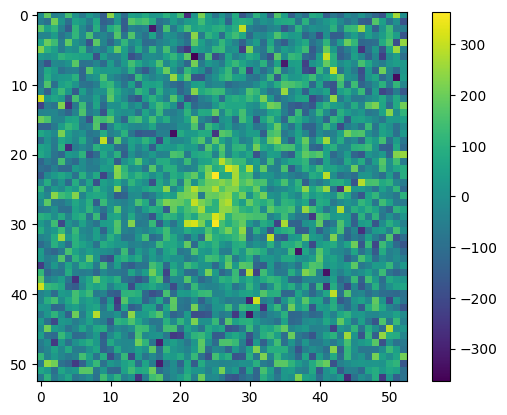

In [9]:
im_nn = _draw_gal()
im = add_noise(im_nn, BACKGROUND)[0][0] ## does not add background just noise
plt.imshow(im)
plt.colorbar()

In [13]:
print(get_snr(im_nn, BACKGROUND))

18.25107


In [14]:
from functools import partial
# jax drawing
GSPARAMS = xgalsim.GSParams(minimum_fft_size=256, maximum_fft_size=256)

def draw_gal(f, hlr, g1, g2):
    gal = xgalsim.Gaussian(flux=10**f, half_light_radius=hlr)
    gal = gal.shear(g1=g1, g2=g2)
    
    psf = xgalsim.Gaussian(flux=1., half_light_radius=PSF_HLR)
    gal_conv = xgalsim.Convolve([gal, psf]).withGSParams(GSPARAMS)
    image = gal_conv.drawImage(nx=SLEN,ny=SLEN,scale=PIXEL_SCALE,
                                 )
    return image.array

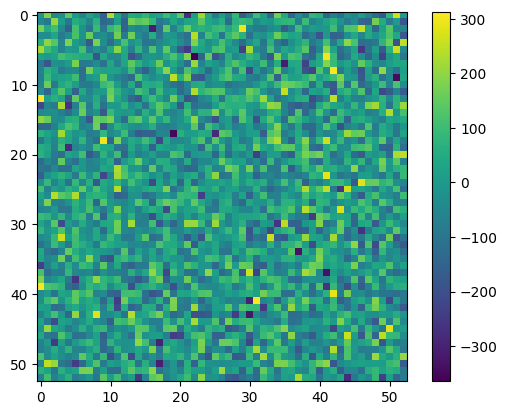

In [15]:
# sanity check 1
res = im - draw_gal(**TRUE_PARAMS)
plt.imshow(res)
plt.colorbar()

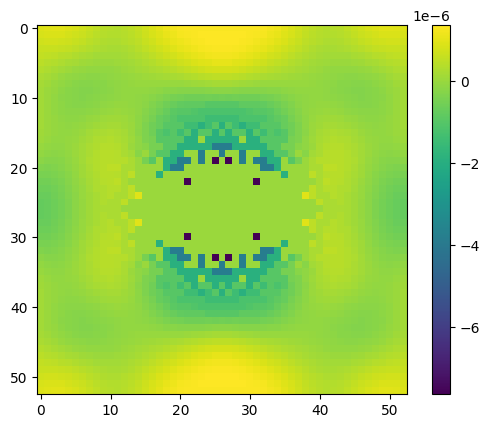

In [16]:
# sanity check 2
res = im_nn - draw_gal(**TRUE_PARAMS)
plt.imshow(res)
plt.colorbar()

In [28]:
# timing makes sense
draw_gal_jitted = jax.jit(draw_gal)
draw_gal_jitted(**TRUE_PARAMS)

%timeit draw_gal_jitted(**TRUE_PARAMS) # ~ twice fast
%timeit _draw_gal()

165 μs ± 1.27 μs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
403 μs ± 1.24 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


# blackjax single chain

## setup

In [29]:
TRUE_PARAMS_GPU = jax.device_put(TRUE_PARAMS, device=GPU)
BACKGROUND_GPU = jax.device_put(BACKGROUND, device=GPU)
BOUNDS = {'f': (4., 5.), 'hlr': (0.7, 1.2), 'g1': (-0.1, 0.1), 'g2': (-0.1, 0.1)
}
BOUNDS_GPU = jax.device_put(BOUNDS, device=GPU)

In [30]:
def logdensity_fn(params, data):
    f = params['f']
    hlr = params['hlr']
    g1 = params['g1'] 
    g2 = params['g2'] 
    
    #prior
    prior = jax.device_put(0.,device=GPU) 
    for p in params:
        b1, b2 = BOUNDS_GPU[p]
        prior += stats.uniform.logpdf(params[p], b1, b2-b1)

             
    # likelihood
    model = draw_gal(**params)
    likelihood = stats.norm.logpdf(data, loc=model, scale=jnp.sqrt(BACKGROUND_GPU))
    
    return jnp.sum(prior) + jnp.sum(likelihood)

In [31]:
def inference_loop(rng_key, kernel, initial_state, n_samples):
    # one chain

    @jax.jit
    def one_step(state, rng_key):
        state, _ = kernel(rng_key, state)
        return state, state

    keys = jax.random.split(rng_key, n_samples)
    _, states = jax.lax.scan(one_step, initial_state, keys)

    return states

## Timing separate parts of a single chain

In [26]:
data = add_noise(_draw_gal(), BACKGROUND, n=1)[0][0]
data_gpu = jax.device_put(data, device=GPU)
data_gpu.devices(), type(data_gpu), data_gpu.shape

({CudaDevice(id=0)}, jaxlib.xla_extension.ArrayImpl, (53, 53))

In [ ]:
# trick that allows for data to be vmapped later
logdensity = jjit(partial(logdensity_fn, data=data_gpu)) # jitting? 

In [51]:
rng_key = jax.device_put(jax.random.key(44), device=GPU)
rng_key, warmup_key, sample_key = jax.random.split(rng_key, 3)

In [52]:
# initial positions
initial_position = {**TRUE_PARAMS_GPU}

In [53]:
with jax.transfer_guard('log'):
    logdensity(initial_position) # no transfer guard issue here
    jax.value_and_grad(logdensity)(initial_position) ### not sure how to avoid transfer in this case

2024-08-15 11:23:40.044157: W external/xla/xla/python/transfer_guard_lib.cc:138] device-to-host transfer: shape=(), dtype=F64, device=cuda:0
2024-08-15 11:23:40.044800: W external/xla/xla/python/transfer_guard_lib.cc:138] device-to-host transfer: shape=(), dtype=F64, device=cuda:0
2024-08-15 11:23:40.044993: W external/xla/xla/python/transfer_guard_lib.cc:138] device-to-host transfer: shape=(), dtype=F64, device=cuda:0
2024-08-15 11:23:40.045299: W external/xla/xla/python/transfer_guard_lib.cc:138] device-to-host transfer: shape=(), dtype=F64, device=cuda:0
2024-08-15 11:23:40.045442: W external/xla/xla/python/transfer_guard_lib.cc:138] device-to-host transfer: shape=(), dtype=F64, device=cuda:0
2024-08-15 11:23:40.045559: W external/xla/xla/python/transfer_guard_lib.cc:138] device-to-host transfer: shape=(), dtype=F64, device=cuda:0
2024-08-15 11:23:40.045673: W external/xla/xla/python/transfer_guard_lib.cc:138] device-to-host transfer: shape=(), dtype=F64, device=cuda:0
2024-08-15 11

In [26]:
# adaptation time as a function fo n_steps
ts = [] 
for n_steps in tqdm(range(1, 1001, 100)):
    t1 = time.time()
    warmup = blackjax.window_adaptation(blackjax.nuts, logdensity, progress_bar=False, is_mass_matrix_diagonal=False)
    (state, parameters), adapt_info = warmup.run(warmup_key, initial_position, num_steps=n_steps)
    _ = state.position['f'].block_until_ready()
    t2 = time.time()
    ts.append(t2-t1)



100%|██████████| 10/10 [01:05<00:00,  6.57s/it]


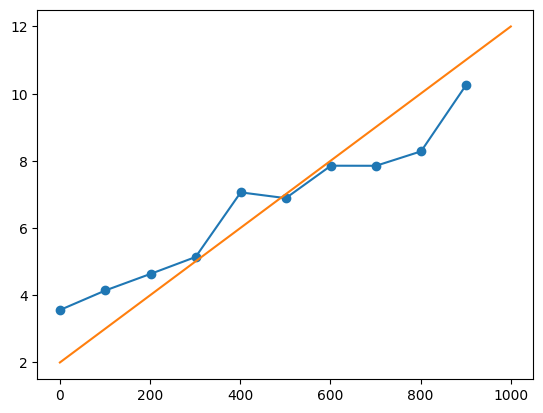

In [27]:
plt.plot(range(1, 1001, 100), ts, '-o')
plt.plot([0, 1000], [2, 12])

In [54]:
# adaptation
warmup = blackjax.window_adaptation(blackjax.nuts, logdensity, progress_bar=False, is_mass_matrix_diagonal=False)
(state, parameters), adapt_info = warmup.run(warmup_key, initial_position, num_steps=500,)
parameters

{'step_size': Array(0.26265025, dtype=float64, weak_type=True),
 'inverse_mass_matrix': Array([[ 1.20522880e-03,  2.88943808e-05, -9.29813487e-05,
          1.77821007e-03],
        [ 2.88943808e-05,  2.31038997e-03,  4.69065172e-04,
          3.84217646e-04],
        [-9.29813487e-05,  4.69065172e-04,  2.72642091e-03,
         -2.03523645e-04],
        [ 1.77821007e-03,  3.84217646e-04, -2.03523645e-04,
          6.81373615e-03]], dtype=float64)}

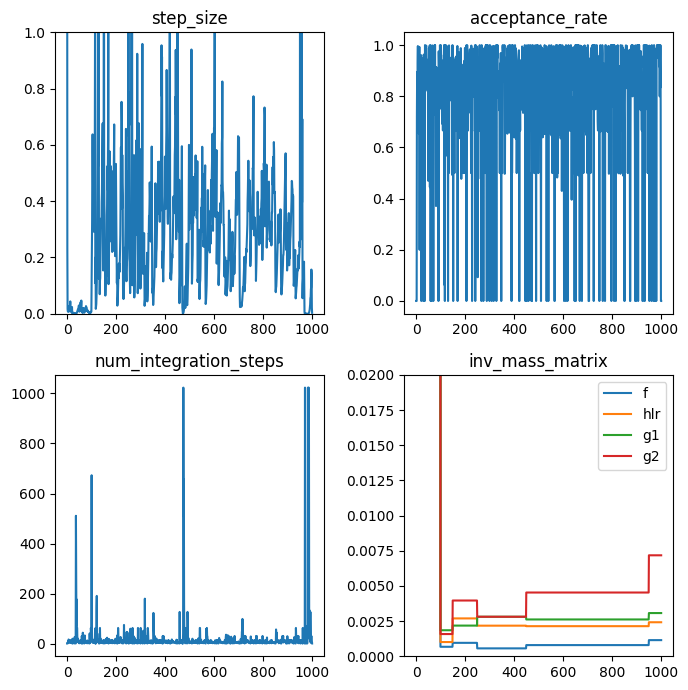

In [31]:
fig, axs = plt.subplots(2,2, figsize=(7,7))
(ax1, ax2, ax3, ax4) = axs.ravel()
ax1.plot(adapt_info.adaptation_state.step_size)
ax1.set_title('step_size')
ax1.set_ylim(0, 1.0)

ax2.plot(adapt_info.info.acceptance_rate)
ax2.set_title('acceptance_rate')


ax3.plot(adapt_info.info.num_integration_steps)
ax3.set_title('num_integration_steps')

# inverse matrix
ax4.plot(adapt_info.adaptation_state.inverse_mass_matrix[:, 0, 0], label='f')
ax4.plot(adapt_info.adaptation_state.inverse_mass_matrix[:, 1, 1], label='hlr')
ax4.plot(adapt_info.adaptation_state.inverse_mass_matrix[:, 2, 2], label='g1')
ax4.plot(adapt_info.adaptation_state.inverse_mass_matrix[:, 3, 3], label='g2')
ax4.set_ylim(0.0, 0.02)
ax4.legend()

ax4.set_title('inv_mass_matrix')

plt.tight_layout()

In [55]:
kernel = jjit(blackjax.nuts(logdensity, **parameters).step) # not jitted by default

In [294]:
# adaptation time as a function fo n_steps
ts = [] 
for n_samples in tqdm(range(1, 1001, 100)):
    t1 = time.time()
    states = inference_loop(sample_key, kernel, state, n_samples=n_samples)
    _ = states.position['f'].block_until_ready()
    t2 = time.time()
    ts.append(t2-t1)




100%|██████████| 10/10 [00:44<00:00,  4.45s/it]


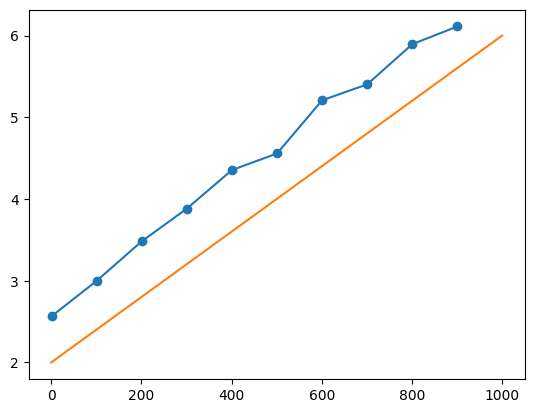

In [296]:
plt.plot(range(1, 1001, 100), ts, '-o')
plt.plot([0, 1000], [2, 6])

In [56]:
%%time
# now run to get actual samples
states = inference_loop(sample_key, kernel, state, n_samples=1000)

CPU times: user 7.6 s, sys: 76.2 ms, total: 7.67 s
Wall time: 7.48 s


In [57]:
samples = states.position

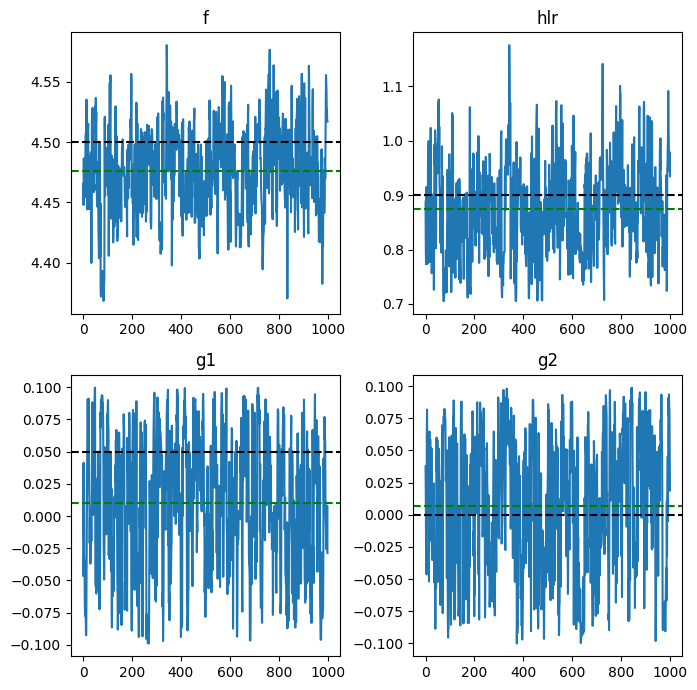

In [58]:
fig, axs = plt.subplots(2,2, figsize=(7,7))
(ax1, ax2, ax3, ax4) = axs.ravel()
ax1.plot(samples['f'])
ax1.set_title('f')
ax1.axhline(TRUE_PARAMS['f'], color='k', linestyle='--')
ax1.axhline(samples['f'].mean(), color='g', linestyle='--')

ax2.plot(samples['hlr'])
ax2.set_title('hlr')
ax2.axhline(TRUE_PARAMS['hlr'], color='k', linestyle='--')
ax2.axhline(samples['hlr'].mean(), color='g', linestyle='--')

ax3.plot(samples['g1'])
ax3.set_title('g1')
ax3.axhline(TRUE_PARAMS['g1'], color='k', linestyle='--')
ax3.axhline(samples['g1'].mean(), color='g', linestyle='--')


ax4.plot(samples['g2'])
ax4.set_title('g2')
ax4.axhline(TRUE_PARAMS['g2'], color='k', linestyle='--')
ax4.axhline(samples['g2'].mean(), color='g', linestyle='--')

plt.tight_layout()

## Time entire thing on different noise realizations

Also interesting to average over different seeds and noise realizations

In [33]:
from functools import partial

def _run_one_chain(rng_key, data, logdensity_fn, n_warmup=300, n_samples=1000):
    
    # keys
    rng_key, warmup_key, sample_key = jax.random.split(rng_key, 3)

    # trick that allows for data to be vmapped later
    logdensity = jjit(partial(logdensity_fn, data=data))
    
    # initial positions
    initial_position = {**TRUE_PARAMS_GPU}
    
    # adaptation
    t1 = time.time()
    warmup = blackjax.window_adaptation(blackjax.nuts, logdensity, progress_bar=False, is_mass_matrix_diagonal=False)
    (state, parameters), _ = warmup.run(warmup_key, initial_position, num_steps=n_warmup)
    t2 = time.time()
    warm_time = t2 - t1
    
    t1 = time.time()
    kernel = jjit(blackjax.nuts(logdensity, **parameters).step) # not jitted by default
    states = inference_loop(sample_key, kernel, state, n_samples)
    t2 = time.time()
    run_time = t2 - t1
    
    return states.position, warm_time, run_time

run_one_chain = partial(_run_one_chain, logdensity_fn=logdensity_fn, n_warmup=300, n_samples=1000)


In [34]:
# run 10 chains
samples = [] 
warmup_times = [] 
run_times = [] 
for ii in tqdm(range(10)):
    data = add_noise(_draw_gal(), BACKGROUND, n=1)[0][0]
    data_gpu = jax.device_put(data, device=GPU)
    rng_key = jax.device_put(jax.random.key(ii), device=GPU)
    s, wt, rt = run_one_chain(rng_key, data_gpu)
    
    samples.append(s)
    warmup_times.append(wt)
    run_times.append(rt)
    


100%|██████████| 10/10 [02:53<00:00, 17.39s/it]


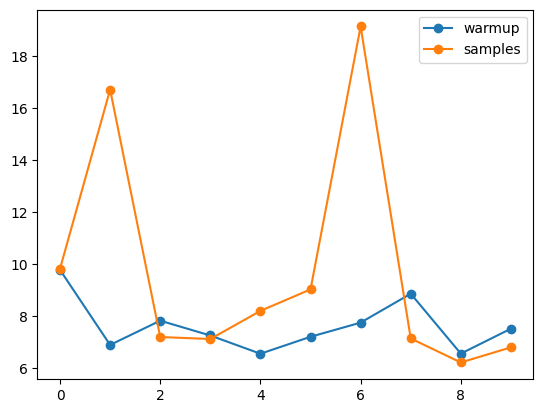

In [36]:
plt.plot(warmup_times, '-o', label='warmup')
plt.plot(run_times, '-o', label='samples')
plt.legend()

In [37]:
from blackjax.diagnostics import effective_sample_size, potential_scale_reduction

In [43]:
chains = {} 
for p in samples[0].keys():
    chains[p] = jnp.concatenate([s[p].reshape(1, 1000) for s in samples])

In [45]:
chains['f'].shape, chains['g1'].shape

((10, 1000), (10, 1000))

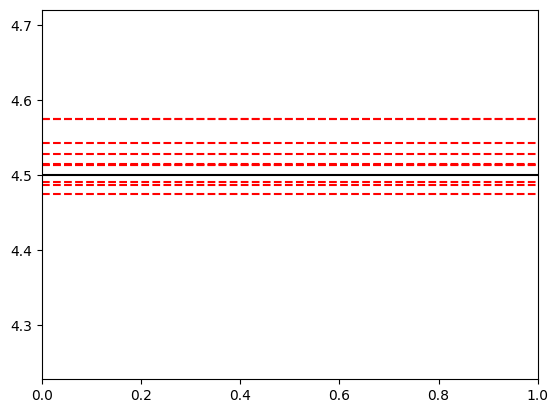

In [47]:
for ii in range(10):
    plt.axhline(chains['f'][ii].mean(), linestyle='--', color='r')
plt.axhline(TRUE_PARAMS['f'], linestyle='-', color='k')

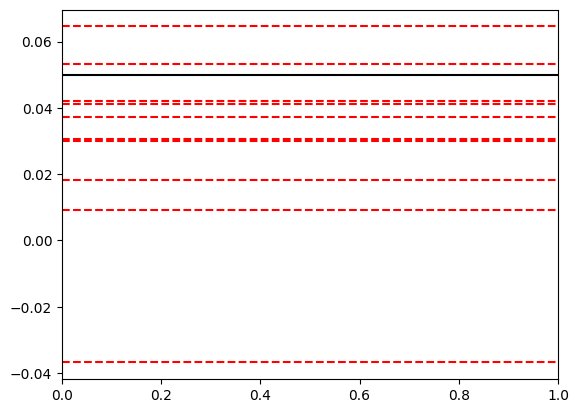

In [52]:
for ii in range(10):
    plt.axhline(chains['g1'][ii].mean(), linestyle='--', color='r')
plt.axhline(TRUE_PARAMS['g1'], linestyle='-', color='k')

# Run multilpe chains on same noise realization to check diagnostics

In [55]:
# run 10 chains
samples = [] 
warmup_times = [] 
run_times = [] 

data = add_noise(_draw_gal(), BACKGROUND, n=1)[0][0]
data_gpu = jax.device_put(data, device=GPU)
for ii in tqdm(range(10)):
    rng_key = jax.device_put(jax.random.key(ii), device=GPU)
    s, wt, rt = run_one_chain(rng_key, data_gpu)
    
    samples.append(s)
    warmup_times.append(wt)
    run_times.append(rt)
    


100%|██████████| 10/10 [02:48<00:00, 16.80s/it]


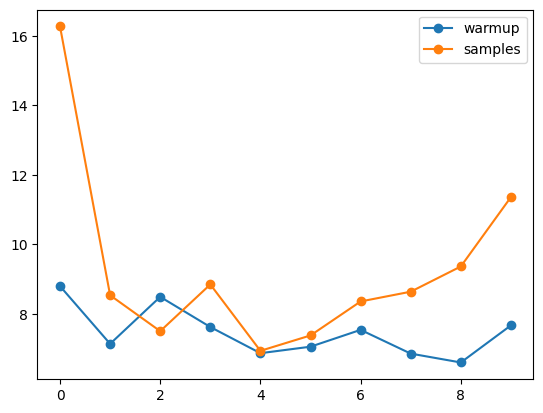

In [77]:
plt.plot(warmup_times, '-o', label='warmup')
plt.plot(run_times, '-o', label='samples')
plt.legend()

In [56]:
chains = {} 
for p in samples[0].keys():
    chains[p] = jnp.concatenate([s[p].reshape(1, 1000) for s in samples])

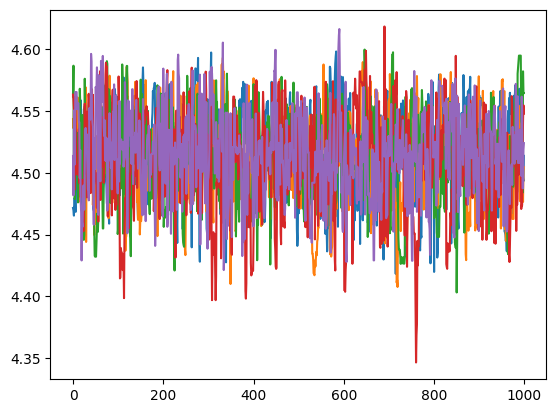

In [60]:
# target same noise realization
for ii in range(5):
    plt.plot(chains['f'][ii]) # very similar

In [61]:
from blackjax.diagnostics import effective_sample_size, potential_scale_reduction

In [68]:
print('ess')
print()
for p in chains: 
    print(p, effective_sample_size(chains[p], chain_axis=0 ,sample_axis=1))
    
print()
print('r-hat')
print()
for p in chains: 
    print(p, potential_scale_reduction(chains[p], chain_axis=0 ,sample_axis=1))

ess

f 2102.3391618606033
g1 1623.9272897298108
g2 1353.436155234773
hlr 1843.858324649199

r-hat

f 1.0023171014745915
g1 1.0039532315679514
g2 1.0085197889936903
hlr 1.0018364475747452


In [72]:
arviz.ess(np.array(chains['g1'])) # close enough to arviz

1602.5690474192818


# Blackjax vmap

In [78]:
n_chains = 10

In [79]:
data, _ = add_noise(_draw_gal(), BACKGROUND, n=n_chains)
data.shape, type(data)

((10, 53, 53), numpy.ndarray)

In [80]:
data_gpu = jax.device_put(data, device=jax.devices('gpu')[0])
data_gpu.devices(), type(data_gpu), data_gpu.shape

({CudaDevice(id=0)}, jaxlib.xla_extension.ArrayImpl, (10, 53, 53))

In [81]:
TRUE_PARAMS_GPU = jax.device_put(TRUE_PARAMS, device=jax.devices('gpu')[0])
BACKGROUND_GPU = jax.device_put(BACKGROUND, device=jax.devices('gpu')[0])

In [21]:
rng_key = jax.device_put(jax.random.key(42), device=jax.devices('gpu')[0])
d1 = data_gpu[0]

In [22]:
%%time 

# with jax.transfer_guard("log"): # need to ensure no warnings here (particularly concerning is the last one)
samples = run_one_chain(rng_key, d1)

CPU times: user 16 s, sys: 456 ms, total: 16.4 s
Wall time: 16.1 s


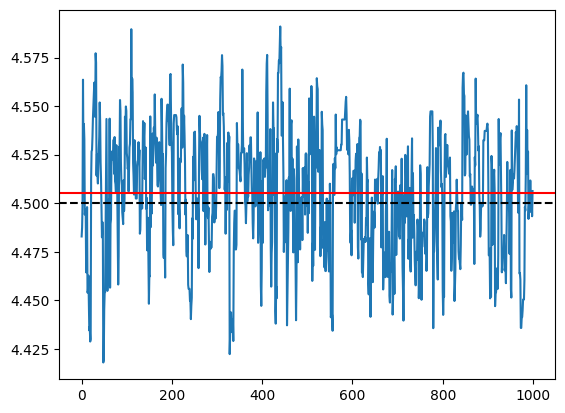

In [23]:
plt.plot(samples['f'])
plt.axhline(samples['f'].mean(), color='r')
plt.axhline(LOG_FLUX, color='k', linestyle='--')

## run multiple chains

In [24]:
# run multiple chains
n_chains = data_gpu.shape[0]
rng_key = jax.random.key(42)
keys = jax.random.split(rng_key, n_chains)

n_chains

10

In [25]:
run_multiple_chains = jax.vmap(run_one_chain)


In [26]:
%%time

samples = run_multiple_chains(keys, data_gpu)

CPU times: user 1min 2s, sys: 485 ms, total: 1min 3s
Wall time: 1min


In [36]:
samples['g1'].shape

(10, 1000)

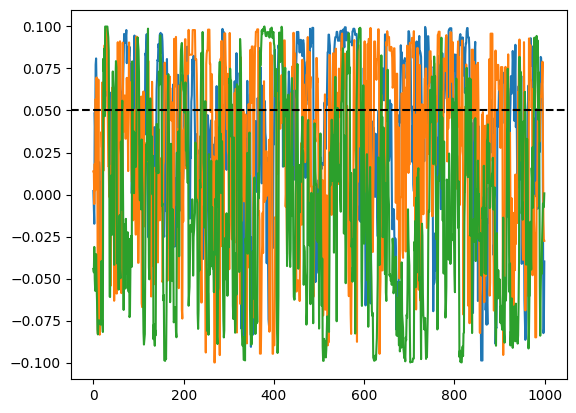

In [34]:
for ii in range(3):

    plt.plot(samples['g1'][ii])
plt.axhline(G1, color='k', linestyle='--')

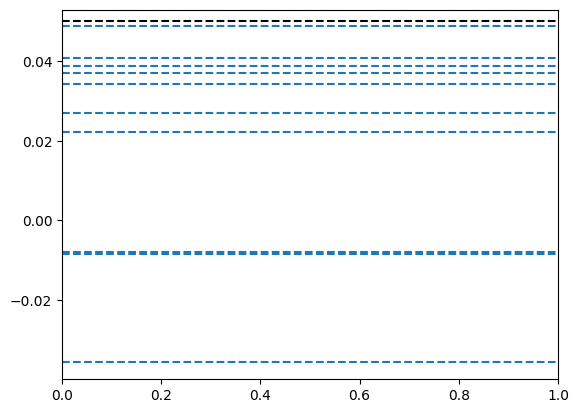

In [35]:
for ii in range(10):

    plt.axhline(samples['g1'][ii].mean(), linestyle='--')
plt.axhline(G1, color='k', linestyle='--')